In [1]:
# for reading and validating data
import emeval.input.spec_details as eisd
import emeval.input.phone_view as eipv
import emeval.input.eval_view as eiev

In [2]:
# Visualization helpers
import emeval.viz.phone_view as ezpv
import emeval.viz.eval_view as ezev

In [3]:
# For computation
import numpy as np
import shapely
import scipy.stats as stats
import matplotlib.pyplot as plt
from shapely import geometry
from scipy.spatial.distance import directed_hausdorff

In [4]:
DATASTORE_URL = "http://cardshark.cs.berkeley.edu"
AUTHOR_EMAIL = "shankari@eecs.berkeley.edu"
sdunp = eisd.SpecDetails(DATASTORE_URL, AUTHOR_EMAIL, "unimodal_trip_car_bike_mtv_la")

About to retrieve messages using {'user': 'shankari@eecs.berkeley.edu', 'key_list': ['config/evaluation_spec'], 'start_time': 0, 'end_time': 1564555974}
response = <Response [200]>
Found 11 entries
After iterating over 11 entries, entry found
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-19T17:00:00-07:00 -> 2019-07-30T17:00:00-07:00


In [5]:
import importlib
importlib.reload(ezpv)

<module 'emeval.viz.phone_view' from '/Users/harivenugopalan/e-mission-eval-public-data/emeval/viz/phone_view.py'>

In [6]:
pvunp = eipv.PhoneView(sdunp)

-------------------- About to read transitions from server --------------------
Reading data for android phones
Loading transitions for phone ucb-sdb-android-1
About to retrieve messages using {'user': 'ucb-sdb-android-1', 'key_list': ['manual/evaluation_transition'], 'start_time': 1563580800, 'end_time': 1564531200}
response = <Response [200]>
Found 41 entries
Loading transitions for phone ucb-sdb-android-2
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['manual/evaluation_transition'], 'start_time': 1563580800, 'end_time': 1564531200}
response = <Response [200]>
Found 41 entries
Loading transitions for phone ucb-sdb-android-3
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['manual/evaluation_transition'], 'start_time': 1563580800, 'end_time': 1564531200}
response = <Response [200]>
Found 41 entries
Loading transitions for phone ucb-sdb-android-4
About to retrieve messages using {'user': 'ucb-sdb-android-4', 'key_list': ['manual/

response = <Response [200]>
Found 11 entries
About to retrieve messages using {'user': 'ucb-sdb-android-1', 'key_list': ['background/battery'], 'start_time': 1564351305.633, 'end_time': 1564360156.392}
response = <Response [200]>
Found 9 entries
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/battery'], 'start_time': 1564274304.968, 'end_time': 1564282402.886}
response = <Response [200]>
Found 10 entries
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/battery'], 'start_time': 1564334125.764, 'end_time': 1564343115.071}
response = <Response [200]>
Found 15 entries
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/battery'], 'start_time': 1564351292.705, 'end_time': 1564360115.769}
response = <Response [200]>
Found 11 entries
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['background/battery'], 'start_time': 1564274288.319, 'end_time': 1564282

response = <Response [200]>
Found 1807 entries
Retrieved 1807 entries with timestamps [1564334483, 1564282348, 1564334538, 1564334539, 1564334540, 1564334541, 1564334542, 1564334543, 1564334544, 1564334545]...
About to retrieve data for ucb-sdb-android-2 from 1564341168 -> 1564343115.071
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/location'], 'start_time': 1564341168, 'end_time': 1564343115.071}
response = <Response [200]>
Found 4 entries
Retrieved 4 entries with timestamps [1564341165, 1564341166, 1564341167, 1564341168]...
About to retrieve data for ucb-sdb-android-2 from 1564341168 -> 1564343115.071
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/location'], 'start_time': 1564341168, 'end_time': 1564343115.071}
response = <Response [200]>
Found 4 entries
Retrieved 4 entries with timestamps [1564341165, 1564341166, 1564341167, 1564341168]...
About to retrieve data for ucb-sdb-android-2 from 1564351292

response = <Response [200]>
Found 1410 entries
Retrieved 1410 entries with timestamps [1564334602.2875528, 1564334605.343677, 1564334605.35634, 1564334608.9970002, 1564334609.9970446, 1564334610.9972146, 1564334611.9973783, 1564334612.9975357, 1564334613.9976838, 1564334614.9978194]...
About to retrieve data for ucb-sdb-ios-2 from 1564341003.9938674 -> 1564342987.826695
About to retrieve messages using {'user': 'ucb-sdb-ios-2', 'key_list': ['background/location'], 'start_time': 1564341003.9938674, 'end_time': 1564342987.826695}
response = <Response [200]>
Found 1 entries
Retrieved 1 entries with timestamps [1564341003.9938674]...
About to retrieve data for ucb-sdb-ios-2 from 1564351227.1936831 -> 1564360024.574613
About to retrieve messages using {'user': 'ucb-sdb-ios-2', 'key_list': ['background/location'], 'start_time': 1564351227.1936831, 'end_time': 1564360024.574613}
response = <Response [200]>
Found 1479 entries
Retrieved 1479 entries with timestamps [1564351652.800541, 156435165

response = <Response [200]>
Found 174 entries
Retrieved 174 entries with timestamps [1564274558.997, 1564274567.579, 1564274576.945, 1564274585.198, 1564274591.018, 1564274599.194, 1564274612.583, 1564274625.507, 1564274638.464, 1564274651.516]...
About to retrieve data for ucb-sdb-android-2 from 1564280649.739 -> 1564282402.886
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/motion_activity'], 'start_time': 1564280649.739, 'end_time': 1564282402.886}
response = <Response [200]>
Found 1 entries
Retrieved 1 entries with timestamps [1564280649.739]...
motion activity has not been processed, copying write_ts -> ts
About to retrieve data for ucb-sdb-android-2 from 1564334125.764 -> 1564343115.071
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/motion_activity'], 'start_time': 1564334125.764, 'end_time': 1564343115.071}
response = <Response [200]>
Found 166 entries
Retrieved 166 entries with timestamps [15643345

response = <Response [200]>
Found 472 entries
Retrieved 472 entries with timestamps [1564351283.6382508, 1564351323.8419127, 1564351326.3507926, 1564351471.793641, 1564351564.5028896, 1564351577.031905, 1564351597.0661352, 1564351617.101654, 1564351629.6283417, 1564351682.2153893]...
About to retrieve data for ucb-sdb-ios-1 from 1564359606.3683307 -> 1564359997.0496612
About to retrieve messages using {'user': 'ucb-sdb-ios-1', 'key_list': ['background/motion_activity'], 'start_time': 1564359606.3683307, 'end_time': 1564359997.0496612}
response = <Response [200]>
Found 1 entries
Retrieved 1 entries with timestamps [1564359606.3683307]...
About to retrieve data for ucb-sdb-ios-2 from 1564274252.429922 -> 1564282305.5882301
About to retrieve messages using {'user': 'ucb-sdb-ios-2', 'key_list': ['background/motion_activity'], 'start_time': 1564274252.429922, 'end_time': 1564282305.5882301}
response = <Response [200]>
Found 257 entries
Retrieved 257 entries with timestamps [1564274267.35568

response = <Response [200]>
Found 1 entries
transition has not been processed, creating ts -> fmt_time
About to retrieve messages using {'user': 'ucb-sdb-android-1', 'key_list': ['statemachine/transition'], 'start_time': 1564334117.295, 'end_time': 1564343045.9}
response = <Response [200]>
Found 3 entries
transition has not been processed, creating ts -> fmt_time
About to retrieve messages using {'user': 'ucb-sdb-android-1', 'key_list': ['statemachine/transition'], 'start_time': 1564351305.633, 'end_time': 1564360156.392}
response = <Response [200]>
Found 3 entries
transition has not been processed, creating ts -> fmt_time
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['statemachine/transition'], 'start_time': 1564274304.968, 'end_time': 1564282402.886}
response = <Response [200]>
Found 6 entries
transition has not been processed, creating ts -> fmt_time
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['statemachine/transition'], 

In [7]:
polygons = []
trips = pvunp.spec_details.curr_spec['evaluation_trips']

for trip in trips:
    for leg in trip['legs']:
        if 'loc' in leg and leg['loc']['geometry']['type'] == 'Polygon':
            polygons.append(geometry.Polygon(leg['loc']['geometry']['coordinates'][0]))
        if 'end_loc' in leg and leg['end_loc']['geometry']['type'] == 'Polygon':
            polygons.append(geometry.Polygon(leg['end_loc']['geometry']['coordinates'][0]))
        if 'start_loc' in leg and leg['start_loc']['geometry']['type'] == 'Polygon':
            polygons.append(geometry.Polygon(leg['start_loc']['geometry']['coordinates'][0]))

In [8]:
def clean(arr):
    """
    Latitude and Longitude defined as np array with shape (n,)
    Reshape to (n,)
    """
    return arr.values.reshape((arr.shape[0], 1))

def is_point_in_polygon(point):
    """
    Utility function to check if given Shapely point
    is contained within a Shapely polygon
    """
    for polygon in polygons:
        if polygon.contains(point):
            return True
    return False

def get_trajectory(df, include_timestamps=True):
    """ 
    Returns np array combining latitudes, longitudes
    and timestamps (if asked for). Only returns those
    points that are not contained within Parking Polygons.
    """
    latitudes = clean(df['latitude'])
    longitudes = clean(df['longitude'])
    if include_timestamps:
        timestamps = clean(df['ts'])
    
    coordinates = np.concatenate((longitudes, latitudes), axis=1).tolist()
    
    data_points = []
    
    for (i, coordinate) in enumerate(coordinates):
        point = geometry.Point(coordinate[0], coordinate[1])
        
        if not is_point_in_polygon(point):
            if include_timestamps:
                coordinate.append(timestamps[i][0])
        data_points.append(coordinate)
    
    return data_points

def get_gt_points(pvunp, phone_os, phone_label, trip_index, section_index):
    """
    Get lat-long corrdinates in ground truth
    """
    data = pvunp.spec_details.curr_spec['evaluation_trips'][trip_index]['legs'][section_index]
    if 'route_coords' in data:
        return data['route_coords']['geometry']['coordinates']
    return []

def get_measured_points(df):
    """
    Get lat-long coordinates recorded from phone
    """
    return get_trajectory(df, include_timestamps=False)

def compute_hausdorff_similarity(base_df, test_df):
    """
    Compute Hausfdorff distance between lat-long-timestamp
    triplets of different measurements.
    """
    base_trajectory = get_trajectory(base_df)
    test_trajectory = get_trajectory(test_df)
    return directed_hausdorff(base_trajectory, test_trajectory)[0]

def get_projections(line, measured_points):
    projections = []
    for p in measured_points:
        point = geometry.Point(p[0], p[1])
        projections.append(point.distance(line))
    return projections

def plot_hist(points):
    plt.hist(points, bins=10)
    plt.show()

In [9]:
spatial_errors = {}


"""
    Spatial errors is a data structure that stores the individual error points (projections) as well as the 
    RMS error for every phone for every one. It is structured as: 
        spatial_errors
        -- ios
        ----ucb-sdb-ios-1
        ------total_error[0] For the different trips
        ------total_error[1]
        .
        .
        ------errors[0] For the different trips
        ------errors[1]
        .
        .
        ----ucb-sdb-ios-2
        .
        .
        -- android
        ----ucb-sdb-android-1
        
"""
for phone_os, phone_map in pvunp.map().items():
    spatial_errors[phone_os] = {}
    
    for phone_label, phone_detail_map in phone_map.items():
        spatial_errors[phone_os][phone_label] = {}
        spatial_errors[phone_os][phone_label]['total_error'] = []
        spatial_errors[phone_os][phone_label]['errors'] = []
        
        for (r_idx, r) in enumerate(phone_detail_map["evaluation_ranges"]):
            run_mean_error = 0.0
            run_errors = []
            
            for (tr_idx, tr) in enumerate(r["evaluation_trip_ranges"]):
                trip_mean_error = 0.0
                trip_errors = []
                    
                for (sr_idx, sr) in enumerate(tr["evaluation_section_ranges"]):
                    gt_points = get_gt_points(pvunp, phone_os, phone_label, tr_idx, sr_idx)
                    
                    if len(sr['location_df']) == 0:
                        continue
                        
                    measured_points = get_measured_points(sr['location_df'])
                    line = geometry.LineString(gt_points)
                    projections = get_projections(line, measured_points)
                    section_error = sum(projections)
                    section_observations = len(projections)
                    section_mean_error = section_error/section_observations
                    trip_mean_error += section_mean_error
                    trip_errors += projections
                    
                run_mean_error += trip_mean_error
                run_errors += trip_errors
                
            spatial_errors[phone_os][phone_label]['total_error'].append(run_mean_error)
            spatial_errors[phone_os][phone_label]['errors'].append(run_errors)

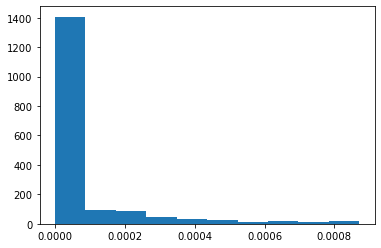

In [10]:
plot_hist(spatial_errors['ios']['ucb-sdb-ios-1']['errors'][0])

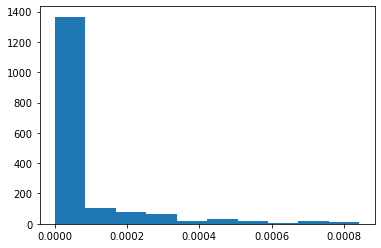

In [11]:
plot_hist(spatial_errors['ios']['ucb-sdb-ios-1']['errors'][1])

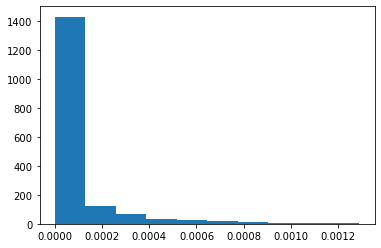

In [12]:
plot_hist(spatial_errors['ios']['ucb-sdb-ios-1']['errors'][2])

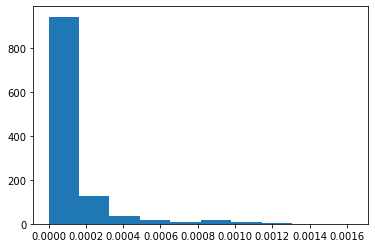

In [13]:
plot_hist(spatial_errors['ios']['ucb-sdb-ios-2']['errors'][0])

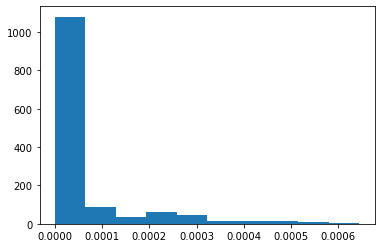

In [14]:
plot_hist(spatial_errors['ios']['ucb-sdb-ios-2']['errors'][1])

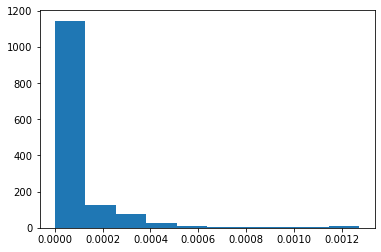

In [15]:
plot_hist(spatial_errors['ios']['ucb-sdb-ios-2']['errors'][2])

In [18]:
# Total error of ucb-sdb-ios-1 
print(spatial_errors['ios']['ucb-sdb-ios-1']['total_error'][0])

0.00017030390904878027
